# Prerequisites

In [72]:
# pip install PyMuPDF                    # (install PyMuPDF for extracting info from PDF files)
# pip install tika                       # (install tika for extracting paragraphs from PDF files)
# pip install spacy==2.2.0               # (install spacy for lemmatization)
# conda install gensim                   # (intall gesim for topic modelling)
# pip install pyLDAvis                   # (install pyLDAvis for topic modelling visulisation)
# conda install -c conda-forge pyldavis  # (if you use aconda to install pyLADvis)

In [73]:
import pandas as pd
import numpy as np
import nltk; nltk.download('stopwords') 
from nltk.corpus import stopwords      # import stop words
stop_words = stopwords.words('english')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>


In [74]:
import re
from pprint import pprint

# glob for extracting the directories of metadata
import glob

# PyMuPDF
import fitz

# tika
import tika               
from tika import parser   

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Visualisation
import plotly.express as px
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

#### define the random  seed as constants

In [75]:
np.random.default_rng(12345)

Generator(PCG64) at 0x2576C87F200

# Import pdf files, data wrangling and overview

In [76]:
# Extract the directories of the PDF files
pdf_dir = "D:\LEON\Business Analytics\Study\9. Business Project\Data set\Crossrail"
pdf_files = glob.glob("%s/*.pdf" % pdf_dir)
pdf_files[3]

'D:\\LEON\\Business Analytics\\Study\\9. Business Project\\Data set\\Crossrail\\British_Railways_(London)_Bill_Lords_(By_Order)_20_Jan_1988.pdf'

In [77]:
# Use PyMuPDF to extract all info of the PDF files (text, title, date, etc)
list_metadata = []
for i in pdf_files:
    with fitz.open(i) as doc:
        info = doc.metadata       
        text = ''
        for page in doc:
            text+= page.getText()
        info['Content'] = text
    list_metadata.append(info)

mupdf: cmsOpenProfileFromMem failed


In [78]:
df = pd.DataFrame(list_metadata)
df.head(3)

,format,title,author,subject,keywords,creator,producer,creationDate,modDate,trapped,encryption,Content
0,PDF 1.7,,Katherine A Bloomfield,,,Microsoft® Word 2019,Microsoft® Word 2019,D:20201012160043+01'00',D:20201012160043+01'00',,None,10-Year Transport Plan \n \n6. \n \nMr. Geoffr...
1,PDF 1.4,,,,,pdftk 2.02 - www.pdftk.com,itext-paulo-155 (itextpdf.sf.net-lowagie.com),D:20190730052236Z,D:20190730052236Z,,None,"House of Commons \nTransport, Local Government..."
2,PDF 1.4,Microsoft Word - 021588,stellent,,,PScript5.dll Version 5.2,Acrobat Distiller 5.0.5 (Windows),D:20041008151844+01'00',D:20041008151844+01'00',,None,AnNew deal for Transport: Better for everyone ...


In [79]:
print(df.loc[0, 'Content']) # content of the first document

10-Year Transport Plan 
 
6. 
 
Mr. Geoffrey Clifton-Brown  (Cotswold) 
If he will make a statement on the recommendations in the recent report 
from the Transport Select Committee relating to the investment programme 
in the 10-year transport plan. [63716] 
 
The Secretary of State for Transport (Mr. Alistair Darling) 
We will respond to the Select Committee report in the normal way. In 
addition, as I said when I was  appointed to this job, 1 am looking at 
all the Department's policies, and I will keep the House informed of 
policy developments as and when appropriate. 
 
Mr. Clifton-Brown 
Paragraph 84 of the Select Committee's stingingly critical report on the 
Government's 10-year plan states: "The Committee remains concerned about 
the lack of clarity surrounding the financing of the rail improvements in 
the 10 Year Plan…The lack of any detailed implementation plan is a major 
barrier to improving the railways." When can we expect from the 
Government some interim targets and a

In [80]:
df = df.drop_duplicates(subset = 'Content') # drop duplicate rows
df = df.dropna(subset=['Content']) # drop rows whose text content is NaN
df['Word_count'] = df ['Content'].str.count(' ') + 1
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229 entries, 0 to 228
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   format        229 non-null    object
 1   title         229 non-null    object
 2   author        229 non-null    object
 3   subject       229 non-null    object
 4   keywords      229 non-null    object
 5   creator       229 non-null    object
 6   producer      229 non-null    object
 7   creationDate  229 non-null    object
 8   modDate       229 non-null    object
 9   trapped       229 non-null    object
 10  encryption    5 non-null      object
 11  Content       229 non-null    object
 12  Word_count    229 non-null    int64 
dtypes: int64(1), object(12)
memory usage: 25.0+ KB


### Word count

In [81]:
# Word count
df['Word_count'].sum( )

11132849

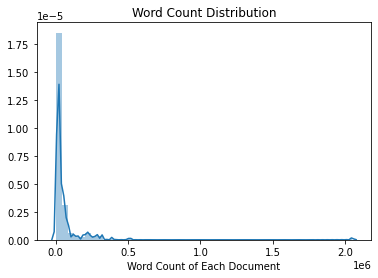

In [82]:
# Word count distribution
import seaborn as sns
ax1 = sns.distplot(df['Word_count'])
ax1.set(title = 'Word Count Distribution',
        xlabel = 'Word Count of Each Document');

# Tokenization

In [83]:
data = df.Content.values.tolist()

In [84]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence).encode('utf-8'), deacc=True))  # deacc=True removes punctuations

data_words1 = list(sent_to_words(data))

#### tripping out short words

In [85]:
minimum_len = 4 # set the length of word threshold for removing the words less than the threshold
data_words = []
for i in data_words1:
    new_element = [x for x in i if len(x) >= minimum_len]
    data_words.append(new_element)
data_words[0]

['year',
 'transport',
 'plan',
 'geoffrey',
 'clifton',
 'brown',
 'cotswold',
 'will',
 'make',
 'statement',
 'recommendations',
 'recent',
 'report',
 'from',
 'transport',
 'select',
 'committee',
 'relating',
 'investment',
 'programme',
 'year',
 'transport',
 'plan',
 'secretary',
 'state',
 'transport',
 'alistair',
 'darling',
 'will',
 'respond',
 'select',
 'committee',
 'report',
 'normal',
 'addition',
 'said',
 'when',
 'appointed',
 'this',
 'looking',
 'department',
 'policies',
 'will',
 'keep',
 'house',
 'informed',
 'policy',
 'developments',
 'when',
 'appropriate',
 'clifton',
 'brown',
 'paragraph',
 'select',
 'committee',
 'stingingly',
 'critical',
 'report',
 'government',
 'year',
 'plan',
 'states',
 'committee',
 'remains',
 'concerned',
 'about',
 'lack',
 'clarity',
 'surrounding',
 'financing',
 'rail',
 'improvements',
 'year',
 'plan',
 'lack',
 'detailed',
 'implementation',
 'plan',
 'major',
 'barrier',
 'improving',
 'railways',
 'when',
 'expect

# Remove Stopwords, Make Bigrams and Trigrams, and Lemmatisation

In [87]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [88]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [89]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
# data_words_bigrams = make_bigrams(data_words_nostops)

# Form Trigrams
data_words_trigrams = make_trigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

#increase the maximum length of text that the parser or NER can process
nlp.max_length = 13000000 #

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['year', 'transport', 'geoffrey_clifton_brown', 'cotswold', 'make', 'statement', 'recommendation', 'recent', 'report', 'transport', 'committee', 'relate', 'investment', 'year', 'transport', 'plan', 'transport', 'committee', 'report', 'normal', 'addition', 'say', 'appoint', 'look', 'department', 'policy', 'keep', 'house', 'informed', 'policy', 'development', 'appropriate', 'committee', 'stingingly', 'critical', 'report', 'government', 'year', 'remain', 'concerned', 'surround', 'financing', 'rail', 'lack', 'detailed', 'implementation', 'plan', 'major', 'barrier', 'improve', 'railway', 'expect', 'government', 'interim', 'target', 'define', 'work', 'programme', 'indeed', 'government', 'respond', 'report', 'revise', 'plan', 'produce', 'matter', 'smuggle', 'summer_recess', 'parliament', 'sit', 'darling', 'report', 'table', 'normal', 'house', 'sit', 'time', 'particularly', 'conservative', 'government', 'funding', 'railway', 'indeed', 'everything_else', 'arrange', 'annual', 'basis', 'governme

#  Create the Dictionary and Corpus needed for Topic Modeling

In [90]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 4), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 3), (22, 1), (23, 3), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 2), (30, 1), (31, 1), (32, 1), (33, 1), (34, 2), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 3), (41, 4), (42, 1), (43, 1), (44, 1), (45, 7), (46, 1), (47, 1), (48, 1), (49, 1), (50, 3), (51, 3), (52, 2), (53, 1), (54, 2), (55, 1), (56, 3), (57, 4), (58, 1), (59, 2), (60, 2), (61, 1), (62, 3), (63, 2), (64, 1), (65, 1), (66, 1), (67, 1), (68, 2), (69, 2), (70, 1), (71, 1), (72, 1), (73, 3), (74, 1), (75, 1), (76, 1), (77, 2), (78, 1), (79, 1), (80, 3), (81, 1), (82, 1), (83, 1), (84, 1), (85, 2), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 2), (103, 2), (104, 7), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1)

# Building LDA Model, Hyperameter (k) tuning

In [91]:
# set training parameters
k = 20
passes = 20
iterations = 100
alpha = 50.0/k   
eta = 0.01

In [93]:
# create the function for computing the coherence score of different models with different number of topics.
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(num_topics=k, corpus=corpus, id2word=id2word, alpha=alpha, eta=eta, iterations=iterations, passes=passes)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [94]:
# apply the function, it might take a long time.
limit=80; start=0; step=5;
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=start, limit=limit, step=step)

In [95]:
# plot the coherence score against number of topics
x = range(start, limit, step)
list_num_topics = [i for i in x]
df_coherence = pd.DataFrame({'Number_of_Topics': list_num_topics, 'Coherence_Score': coherence_values})
fig1 = px.line(df_coherence, x = 'Number_of_Topics', y="Coherence_Score", title = 'Coherence score against number of topics')
fig1.update_layout(autosize=False, width=1000, height=400)
fig1.update_traces(mode = "lines + markers")
fig1.show()

In [109]:
# num of topics = 35 to get the optimal coherence socre
k = 35
lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=id2word,
    alpha=alpha,
    eta=eta,
    iterations=iterations,
    num_topics=k,
    passes=passes)

# Apply the trained model to predict the topics of paragraphs

### Extract paragraphs from documents

In [110]:
# create the function for metadata extraction from documents
def info(i):
    with fitz.open (i) as doc:
        info = doc.metadata
        return info

# create the function for paragraph extraction from documents
def paragraphs_extraction(i):
    j = parser.from_file(i)
    m = j['content']
    n = m.split('\n \n') # split the documents by new lines, if the corpus changes and the paragraphs are not splitted correctly , try to repalce '\n \n' by '\n \n'
    n = [w.replace('\n', '') for w in n]
    return n

In [111]:
list_paragraphs = []
for i in pdf_files:
    with fitz.open(i) as doc:
        info = doc.metadata
        info['paragraphs'] = paragraphs_extraction(i) 
    list_paragraphs.append(info)                      # if it fails, try to rerun it
df_paragraph = pd.DataFrame(list_paragraphs)               # dataframe containing paragraphs of each documents
df_paragraph['document_id'] = df_paragraph.index             # set the index as the document id

# split the list of paragraphs into rows
df_para  = df_paragraph.set_index(['document_id'])['paragraphs'].apply(pd.Series)\
                                         .stack()\
                                         .reset_index(level=1, drop=True)
df_para = df_para.reset_index()
df_para = df_para.rename(columns={0: "paragraphs"})
df_para['paragraphs'] = [w.replace('\t', '') for w in df_para['paragraphs']] # remove tab in texts
df_para = df_para[df_para['paragraphs'].str.strip() !=''] # drop rows whose text content is NaN
df_para = df_para.dropna(subset=['paragraphs']) 
df_para = df_para.reset_index()
df_para

,index,document_id,paragraphs
0,0,0,10-Year Transport Plan
1,1,0,6.
2,2,0,Mr. Geoffrey Clifton-Brown (Cotswold) If he w...
3,3,0,The Secretary of State for Transport (Mr. Alis...
4,4,0,Mr. Clifton-Brown Paragraph 84 of the Select C...
...,...,...,...
11626,11849,228,Mr. Spellar That was rather ungallant of Oppos...
11627,11850,228,Chris Grayling (Epsom and Ewell) The Governme...
11628,11851,228,"Mr. Spellar That is fine cheek, coming from a ..."
11629,11852,228,Andrew Bennett (Denton and Reddish) Does my r...


In [112]:
df_para.loc[11629, 'paragraphs']

'Andrew Bennett  (Denton and Reddish) Does my right hon. Friend accept that, although commuters in Greater Manchester are prepared to put up with a deterioration in  the service while the west coast main line is being upgraded, they want the certainty that services will be restored to at least their former level, if not improved? '

### Predict topics of paragraphs

In [113]:
# create function for topic extraction
def topic_extraction(i):
    doc = i.split()
    doc_vector = lda_model.id2word.doc2bow(doc)
    doc_topics = lda_model[doc_vector]
    return doc_topics

# create the function for converting a list of tuples into a dictionary
def Convert(tup, di):
    di = dict(tup)
    return di

In [114]:
# predict topics of paragraphs
list_topic_para = []
dictionary_topic_para = {}
for i in df_para['paragraphs']:
    doc = i.split()
    doc_vector = lda_model.id2word.doc2bow(doc)
    doc_topics = lda_model[doc_vector]
    doc_dic = Convert(doc_topics, dictionary_topic_para)
    list_topic_para.append(doc_dic)
    df_topic_para = pd.DataFrame(list_topic_para)
df_topic_para1 = pd.merge(df_para, df_topic_para, how = 'left', left_index=True, right_index=True)
df_topic_para1 = df_topic_para1.drop(columns = 'index')
df_topic_para1

,document_id,paragraphs,0,1,2,3,4,5,6,7,...,25,26,27,28,29,30,31,32,33,34
0,0,10-Year Transport Plan,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,...,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571
1,0,6.,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,...,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571
2,0,Mr. Geoffrey Clifton-Brown (Cotswold) If he w...,0.025277,0.034000,0.025825,0.025278,0.025403,0.051925,0.030807,0.026602,...,0.027816,0.028886,0.025383,0.025312,0.026869,0.025485,0.025327,0.025461,0.026379,0.025673
3,0,The Secretary of State for Transport (Mr. Alis...,0.024886,0.031601,0.024916,0.024914,0.024979,0.045215,0.033905,0.027249,...,0.029053,0.032092,0.024872,0.024973,0.027633,0.025043,0.024842,0.025043,0.027390,0.024978
4,0,Mr. Clifton-Brown Paragraph 84 of the Select C...,0.019982,0.063336,0.020463,0.020127,0.020023,0.061959,0.037864,0.023874,...,0.026736,0.031073,0.020175,0.020018,0.023093,0.020169,0.019797,0.020140,0.032385,0.020359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11626,228,Mr. Spellar That was rather ungallant of Oppos...,0.017024,0.041921,0.017166,0.017692,0.017053,0.108139,0.035038,0.029620,...,0.025482,0.035051,0.016983,0.016957,0.032136,0.017170,0.016833,0.017048,0.024392,0.017287
11627,228,Chris Grayling (Epsom and Ewell) The Governme...,0.022950,0.031805,0.023089,0.023477,0.022891,0.066633,0.034984,0.027358,...,0.027695,0.027032,0.022784,0.022911,0.031425,0.023064,0.022852,0.023083,0.027331,0.023200
11628,228,"Mr. Spellar That is fine cheek, coming from a ...",0.022872,0.030058,0.022534,0.023218,0.022646,0.075670,0.033826,0.027798,...,0.023985,0.032267,0.022584,0.022603,0.025791,0.022838,0.022540,0.022961,0.027195,0.022820
11629,228,Andrew Bennett (Denton and Reddish) Does my r...,0.023422,0.039592,0.023480,0.023971,0.023473,0.043304,0.039259,0.027759,...,0.027411,0.036934,0.023448,0.023373,0.031136,0.023528,0.023302,0.023457,0.028034,0.023524


# Overview of topics

### The most frequent 10 words of each topic

In [115]:
pprint(lda_model.print_topics())

[(19,
  '0.018*"would" + 0.014*"crossrail" + 0.009*"go" + 0.008*"think" + '
  '0.008*"committee" + 0.008*"work" + 0.007*"station" + 0.007*"take" + '
  '0.006*"point" + 0.006*"make"'),
 (28,
  '0.008*"crossrail" + 0.006*"transport" + 0.005*"would" + 0.004*"service" + '
  '0.004*"make" + 0.003*"government" + 0.003*"year" + 0.003*"public" + '
  '0.002*"line" + 0.002*"work"'),
 (27,
  '0.008*"transport" + 0.006*"make" + 0.005*"would" + 0.004*"year" + '
  '0.004*"service" + 0.004*"project" + 0.004*"government" + 0.003*"scheme" + '
  '0.003*"time" + 0.003*"crossrail"'),
 (20,
  '0.019*"government" + 0.014*"transport" + 0.013*"year" + 0.010*"make" + '
  '0.010*"would" + 0.009*"investment" + 0.008*"public" + 0.008*"say" + '
  '0.008*"people" + 0.007*"line"'),
 (0,
  '0.009*"crossrail" + 0.008*"would" + 0.007*"transport" + 0.005*"make" + '
  '0.004*"line" + 0.003*"year" + 0.003*"work" + 0.003*"project" + 0.003*"give" '
  '+ 0.002*"people"'),
 (3,
  '0.013*"crossrail" + 0.007*"would" + 0.006*"wo

### Topic distribution across documents

In [116]:
# topic distribution over documents
list_topic = []
dictionary_topic = {}
for d in texts:
    bow = id2word.doc2bow(d)
    belong = lda_model[bow]                        # generate a list of tuples of topic distribution of a document
    belong_dic = Convert(belong, dictionary_topic) # convert the list of tuples into a dictionary
    list_topic.append(belong_dic)           
                      
df_topic_distribution = pd.DataFrame(list_topic)   # convert the list of dictionaries into a dataframe
df_topic = pd.merge(df, df_topic_distribution, how = 'left', left_index=True, right_index=True) # merge with info of documents
df_topic.drop(['format','creator', 'producer', 'keywords', 'trapped', 'encryption'], axis = 1)

,title,author,subject,creationDate,modDate,Content,Word_count,1,5,6,...,30,32,34,31,2,12,18,22,27,28
0,,Katherine A Bloomfield,,D:20201012160043+01'00',D:20201012160043+01'00',10-Year Transport Plan \n \n6. \n \nMr. Geoffr...,1437,0.084724,0.018021,0.018634,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,,,D:20190730052236Z,D:20190730052236Z,"House of Commons \nTransport, Local Government...",292641,0.730625,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Microsoft Word - 021588,stellent,,D:20041008151844+01'00',D:20041008151844+01'00',AnNew deal for Transport: Better for everyone ...,67602,0.013588,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,,Katherine A Bloomfield,,D:20200429153449+01'00',D:20200429153449+01'00',British Railways (London) Bill Lords (By Order...,26519,NaN,0.033917,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,,Katherine A Bloomfield,,D:20201012144724+01'00',D:20201012144724+01'00',British Railways Bill \n \nOrder for Second Re...,3167,0.011322,0.014913,0.016074,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,,Katherine A Bloomfield,,D:20201012164224+01'00',D:20201012164224+01'00',Transport: London Underground \n \nLord Bridge...,512,0.025504,0.024763,0.030220,...,0.011837,0.01195,0.011855,0.023786,0.011539,0.011005,0.011302,0.011421,0.011213,0.011275
225,,Katherine A Bloomfield,,D:20201012164258+01'00',D:20201012164258+01'00',Transport: Rail and Air Travel \n \nWhat is mi...,5173,NaN,0.015792,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
226,,Katherine A Bloomfield,,D:20201012155409+01'00',D:20201012155409+01'00',Tube Investment \n \n[Relevant documents: Seve...,59658,0.035816,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,,Katherine A Bloomfield,,D:20201012163723+01'00',D:20201012163723+01'00',Waterloo Station \n \n11:00:00 \n \nSusan Kra...,4714,NaN,NaN,0.011055,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Topic distribution of the whole corpus
As shown below there are only 8 topics with topic distribution above the threshold (1/K);
according to the PTBI proposed by Marchetti and Puranam (2020), the 8 topics are the salient topics worth interpreting.
However, we extracted 35 topics and the 8 topics are not enough to interpret all the documents, so we prefer to interpret all the topics

In [117]:
topic_distribution = df_topic_distribution.sum()/df_topic_distribution.sum().sum()
topics_distribution = pd.DataFrame({'topic_id': topic_distribution.index, 'topic_distribution': topic_distribution, 
                                    'Not_less_than_threshold': topic_distribution >= 1/k})


topics_distribution.sort_values(by = 'topic_distribution', ascending = False)

,topic_id,topic_distribution,Not_less_than_threshold
20,20,0.235319,True
26,26,0.109703,True
25,25,0.069863,True
1,1,0.063476,True
5,5,0.057750,True
10,10,0.054542,True
23,23,0.053254,True
13,13,0.050109,True
9,9,0.042732,True
14,14,0.038804,True


In [118]:
fig2 = px.bar(topics_distribution, x='topic_id', y='topic_distribution',title='Topic distribution of the whole corpus')
fig2.update_layout(autosize=False, width=1000, height=300)
fig2.show()

### Salient topics in each document
I define the salient topics in each document as the topics with probability > 1/k. In other words, the probablity of the salient topic should be more than the random probability

In [119]:
salient_filter = df_topic_distribution >= 1/k
df_salient_topics = df_topic_distribution[salient_filter]
df_salient_topics

,1,5,6,7,8,9,10,11,13,14,...,30,32,34,31,2,12,18,22,27,28
0,0.084724,NaN,NaN,NaN,NaN,0.049360,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.730625,NaN,NaN,NaN,NaN,0.165545,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,0.033917,NaN,0.040580,NaN,NaN,0.028909,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,0.119362,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,NaN,NaN,0.030220,NaN,NaN,NaN,NaN,0.05957,0.130151,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
225,NaN,NaN,NaN,0.041848,0.037054,0.236773,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
226,0.035816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,NaN,NaN,NaN,0.376420,NaN,0.083764,0.060513,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Salient topics in each paragraph

In [120]:
df_salient_topics_para = df_topic_para1.iloc[:, 2:][salient_filter]
df_salient_topics_para

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,NaN,0.028571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028571,...,0.028571,0.028571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.028571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028571,...,0.028571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.027816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,0.045215,NaN,0.027249,NaN,NaN,...,NaN,0.032092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.023874,NaN,NaN,...,NaN,0.031073,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Topic interpretation
To interpret the topics, I combined the word frequncy demonstrated by pyLDAvis with prototypical documents or paragraphs suggested by PTBI proposed by Marchetti and Puranam (2020)

### Word frequency of each topic

In [121]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, sort_topics = False )
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.214989 -0.021796       1        1   0.013838
1      0.142500  0.032337       2        1  11.106007
2     -0.187080  0.034436       3        1   0.015152
3     -0.147078 -0.038750       4        1   0.014848
4     -0.206070  0.007263       5        1   0.013905
5      0.154150 -0.012362       6        1   5.959935
6      0.138632 -0.097518       7        1   3.894825
7      0.160753  0.024943       8        1   1.950790
8      0.022895 -0.009737       9        1   0.134947
9      0.132291  0.043518      10        1   6.864843
10     0.160493  0.058847      11        1   4.414204
11     0.064256  0.160226      12        1   0.317549
12    -0.220577  0.015484      13        1   0.013689
13     0.166778  0.001230      14        1   3.931453
14     0.144390  0.026799      15        1   9.179039
15     0.127614 -0.251457      16        1   1.575809
16     0.157218  0.001093      17        1   1.421549
17     0.162131  0.029771      18        1   2.215629
18    -0.197849  0.009067      19        1   0.013973
19     0.146118 -0.096832      20        1  12.326023
20     0.136793  0.000748      21        1   7.339839
21     0.165663  0.101377      22        1   1.376269
22    -0.245305  0.004770      23        1   0.013996
23     0.162122 -0.000230      24        1   9.259016
24    -0.187987 -0.003435      25        1   0.014023
25     0.161157  0.080688      26        1   8.804217
26     0.130564 -0.097290      27        1   3.060724
27    -0.209286  0.020382      28        1   0.013855
28    -0.236547 -0.005897      29        1   0.013581
29     0.131227 -0.017402      30        1   0.527182
30    -0.192897 -0.008477      31        1   0.014067
31    -0.294247 -0.009633      32        1   0.018816
32    -0.208923 -0.008115      33        1   0.013932
33     0.141174  0.026453      34        1   4.137875
34    -0.160084 -0.000499      35        1   0.014599, topic_info=            Term          Freq         Total Category  logprob  loglift
269    transport  55158.000000  55158.000000  Default  30.0000  30.0000
284        would  45316.000000  45316.000000  Default  29.0000  29.0000
59     crossrail  13837.000000  13837.000000  Default  28.0000  28.0000
151         make  26960.000000  26960.000000  Default  27.0000  27.0000
111   government  24196.000000  24196.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
1685        cost      1.441665  20550.364202  Topic35  -6.0467  -0.7329
268        train      1.374051  18902.289938  Topic35  -6.0948  -0.6973
45     committee      1.179826  13266.006861  Topic35  -6.2471  -0.4956
4916   passenger      1.195221  18884.689280  Topic35  -6.2342  -0.8358
282         work      1.159177  22610.270193  Topic35  -6.2648  -1.0465

[2979 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
25335     26  0.994323        aaib
12871     10  0.024634   abatement
12871     11  0.036951   abatement
12871     14  0.689760   abatement
12871     20  0.061586   abatement
...      ...       ...         ...
43254     11  0.985971      ﬁnance
43256     11  0.987640    ﬁnancial
43268     11  0.972396        ﬂeet
43269     11  0.968526  ﬂexibility
43274     11  0.982225         ﬂow

[10007 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35])

### Prototypical texts for each topic
I followed the method of extraction of prototypical text suggested by PTBI proposed by Marchetti and Puranam (2020). Its heart lies in that for parameter L (probability that a document belongs to a topic), at least 1/L documents with probablity that they belong to the topic >= L are needed to interpret the topics, this method tries to find out the opitimal value of L to maximize the percentage of interpretable topics (Marchetti and Puranam, 2020, p. 20)

In [122]:
List_num_doc = [x for x in range(1, 20, 1)] # generate a list of 1/L (minimum number of documents to interpret a topic)
list_L = [1/x for x in List_num_doc]        # generate a list of L

In [123]:
# create the function for computing the percentage of potentially interpretable topics against parameter L
def perc(i, df):
    list_num_topics = []
    for j in df:                                  
        topic_filter = df[j] >= i         
        m = df[j][topic_filter].count()           
        list_num_topics.append(m)                                             
        count1 = sum(map(lambda x : x >= 1/i, list_num_topics))                                     
        perc1 = count1 / k
    return(perc1)

The following chart shows that the percentage of potentially interpretable topics for “high enough” levels of L is not large enough, so the paragraph-based interpretation can be explored. 

In [124]:
list_perc1 = []
for i in list_L:
    num = perc(i, df_topic_distribution)
    list_perc1.append(num)

df_L1 = pd.DataFrame({'Parameter L': list_L, 'Percentage of interpretable topics': list_perc1})
fig_L1 = px.line(df_L1, x = 'Parameter L', y="Percentage of interpretable topics", title = 'Value selection for parameter L (document-based)')
fig_L1.update_layout(autosize=False, width=1200, height=400)
fig_L1.update_traces(mode = "lines + markers")
fig_L1.show()

The following chart shows that when L = 0.5, the the percentage of interpretable topics is 100%, so we set L = 0.5 - ie, each topic needs at least 2(1/L) paragraphs to be interpreted.

In [125]:
df_topic_para2 = df_topic_para1.drop(['document_id', 'paragraphs'], axis = 1)
list_perc2 = []
for i in list_L:
    num = perc(i, df_topic_para2)
    list_perc2.append(num)

df_L2 = pd.DataFrame({'Parameter L': list_L, 'Percentage of interpretable topics': list_perc2})
fig_L2 = px.line(df_L2, x = 'Parameter L', y="Percentage of interpretable topics", title = 'Value selection for parameter L (paragraph-based )')
fig_L2.update_layout(autosize=False, width=1200, height=400)
fig_L2.update_traces(mode = "lines + markers")
fig_L2.show()

### Prototypical paragraphs of each topic
As we analysed shown above, for each topic we need to find 2 prototypical paragraphs with the highest probablity that they belong to the topic to interpret the topic. 
Then we could combine the prototypical paragraphs with the word frequncy demonstrated by pyLDAvis to interpret the topics.

In [126]:
list_text = []
df_topic_para3 = df_topic_para1.iloc[:, 2:]
for i in range(0, k):
    dict_text = {}
    dict_text['topic_id'] = df_topic_para1.columns[i + 2]
    dict_text['prototypical_para'] = df_topic_para1.nlargest(2, [i])['paragraphs']
    list_text.append(dict_text)
df_proto = pd.DataFrame(list_text)
df_proto

,topic_id,prototypical_para
0,0,0 10-Year Transport Plan 1 ...
1,1,4789 House of Commons Transport Committee L...
2,2,0 10-Year Transport Plan 1 ...
3,3,11272 Mr. Townend: The right hon. Gentleman...
4,4,0 10-Year Transport Plan 1 ...
5,5,4242 186 MINUTES OF EVIDENCE TAKEN BEFORE T...
6,6,798 Government Overview of the Case for Cr...
7,7,4195 Ev 84 Transport Committee: Written Evi...
8,8,"7707 The Earl of Mar and Kellie My Lords, I..."
9,9,10608 House of Commons Transport Committee ...


# Build topic model on paragraphs

In [128]:
# tokenization
data2 = df_para.paragraphs.values.tolist()
data_words2_2 = list(sent_to_words(data2))

In [129]:
# set the length of word threshold for removing the words less than the threshold
minimum_len = 4 
data_words2 = []
for i in data_words2_2:
    new_element = [x for x in i if len(x) >= minimum_len]
    data_words2.append(new_element)

In [130]:
# Bigram & Trigram
bigram2 = gensim.models.Phrases(data_words2, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram2 = gensim.models.Phrases(bigram2[data_words2], threshold=100)  
bigram_mod2 = gensim.models.phrases.Phraser(bigram2)
trigram_mod2 = gensim.models.phrases.Phraser(trigram2)

In [ ]:
# Remove Stop Words
data_words_nostops2 = remove_stopwords(data_words2)

# Form Trigrams
data_words_trigrams2 = make_trigrams(data_words_nostops2)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized2 = lemmatization(data_words_trigrams2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
# Create Dictionary
id2word2 = corpora.Dictionary(data_lemmatized2)

# Create Corpus
texts2 = data_lemmatized2

# Term Document Frequency
corpus2 = [id2word2.doc2bow(text) for text in texts]

In [ ]:
lda_model2 = gensim.models.LdaModel(
    corpus=corpus2,
    id2word=id2word2,
    alpha=alpha,
    eta=eta,
    iterations=iterations,
    num_topics=k,
    passes=passes)

In [ ]:
# Compute Coherence Score
coherence_model_lda2 = CoherenceModel(model=lda_model2, texts=data_lemmatized2, dictionary=id2word2, coherence='c_v')
coherence_lda2 = coherence_model_lda2.get_coherence()
print('\nCoherence Score: ', coherence_lda2)

In [ ]:
# Visualize the topics
vis2 = pyLDAvis.gensim_models.prepare(lda_model2, corpus2, id2word2, sort_topics = False)
vis2